## K-means 均值聚类算法
本遍主要完成，普通 k-means 算法和二分 k-means 算法的实现

### 加载待标注数据

In [15]:
from numpy import *

In [16]:
# 加载数据
def loadDataset(fileName):
    dataArr = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = line.strip().split('\t')
        floatArr = [float(ele) for ele in lineArr]
        dataArr.append(floatArr)
    return mat(dataArr)

In [17]:
dataMat = loadDataset('testSet.txt')

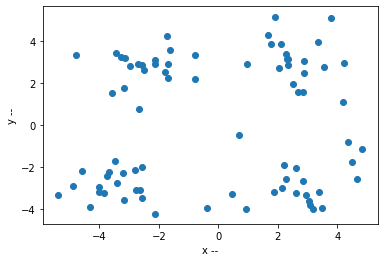

In [18]:
"""
待标注数据
"""
import matplotlib.pyplot as plt
xData = dataMat[:,0]
yData = dataMat[:,1]

plt.scatter(xData.getA().flatten(), yData.getA().flatten())
plt.xlabel('x --')
plt.ylabel('y --')
plt.show()

In [25]:
# 绘制 k-means cluster 数据
def plotKmeans(dataSet, assignMat, centroids, title):
    plt.title(title)
    colors = ['c','r','g','b']
    k = shape(centroids)[0]
    for i in range(k):
        clusterI = dataSet[nonzero(assignMat[:,0].A == i)[0]]
        plt.scatter(clusterI[:, 0].getA().flatten(), clusterI[:, 1].getA().flatten(), c=colors[i])
        plt.scatter(centroids[i,0], centroids[i,1], marker='x', s=40, c='k')
    plt.show()

In [26]:
'''
K-means 算法
'''
from numpy import *

'''
K-means 支持函数
'''
# 欧式距离计算
def calcEclud(vecA, vecB):
    return sqrt(sum(power(vecA - vecB, 2)))

# 随机获取 k 个聚类点
def randCentroids(dataSet, k):
    n = shape(dataSet)[1]
    centroids = mat(zeros((k, n)))
    for i in range(n):
        minValue = min(dataSet[:, i])
        maxValue = max(dataSet[:, i])
        rangeValue = float(maxValue - minValue)
        centroids[:, i] = minValue + rangeValue * random.rand(k, 1)
    return centroids

# kMeans 算法
def kMeans(dataSet, k, calcMeans = calcEclud, createCentroids = randCentroids, innerPrint = False):
    m, n = shape(dataSet)
    assignMat = mat(zeros((m, 2)))
    centroids = createCentroids(dataSet, k)
    changed = True
    times = 0
    while changed:
        if times == 0:
            title = 'Origin Data'
        else:
            title = str(times) + 'th k-menas cluster'
        times += 1
        innerPrint and plotKmeans(dataSet, assignMat, centroids, title)
        changed = False
        for i in range(m):
            # 根据最小距离对样本进行分类
            minDist = inf # inf 是 numpy 中定义的无穷大.
            kLabel = -1
            for j in range(k):
                dist = calcMeans(dataSet[i,:], centroids[j,:])
                if dist < minDist:
                    minDist = dist
                    kLabel = j
            if kLabel != assignMat[i, 0]:
                changed = True
            assignMat[i,:] = kLabel, minDist ** 2
        # 更新 centroids 的新的位置。
        for j in range(k):
            kClusterPoints = dataSet[nonzero(assignMat[:,0] ==j)[0]]
            centroids[j] = mean(kClusterPoints, axis = 0)
    innerPrint and plotKmeans(dataSet, assignMat, centroids, 'Final k-means cluster')
    return centroids, assignMat       

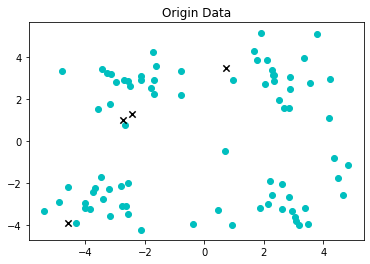

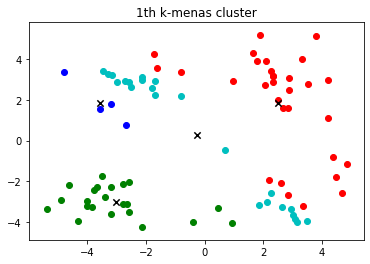

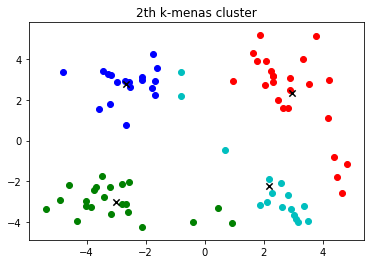

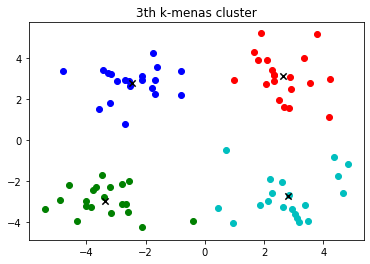

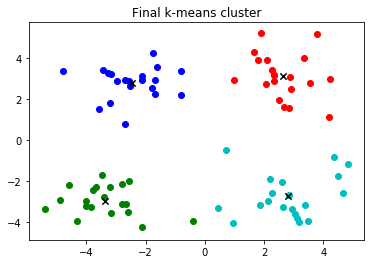

In [27]:
ctds, assignMat = kMeans(dataMat, 4, calcEclud, randCentroids, True)

### Imporving Cluster Performance with postprocessing, 提升性能的后继方法
k-means 算法需要处理的问题是：

1. 如保确定 k 那？如何让用户知道 k 的的选择是正确的那？
2. 如何避免 k-means 算法陷入到局部最优值中。

一种衡量 k-means 算法效果的指标是 SSE（Sum of Squared Error， 误差平方和），SSE 值越小，聚类的效果就越好。
在使用 k-means 算法中可能在后继的处理中可能需要对聚类簇进行拆分或合并。

1. 拆分：拆分的策略是将最大值 SSE 的簇进行拆分
2. 合并：有两种策略 
    - 合并了最近的质心（通过计算两个质心之间的距离）
    - 合并两个使得 SEE 增幅最小的两个质心。
    
当然为了克服 k-means 算法收敛入局部最小值中，我们可以使用下面的二分 k-means 算法。


### Bisecting K-means , 二分 k-means 算法

Bisecting K-means 算法的思想是：首先将所有点作为一个簇，然后将该簇一分为二。之后选择其中一个簇进行划分，选择哪一个簇进行划分取决于对其划分是否可以最大程度降低 SSE 的值。

In [28]:
'''
Bisecting K-means 
'''
def biKmeans(dataSet, k, calcMeans = calcEclud):
    m = shape(dataSet)[0] 
    clusterAssment = mat(zeros((m, 2))) # 用于保存 m 个样本的信息。
    centroid0 = mean(dataSet, axis = 0).tolist()[0] # 创建一个初始质心。
    centList = [centroid0]
    
    # 计算所有点到初始质心 0 的距离。
    for j in range(m):
        clusterAssment[j, 1] = calcMeans(mat(centroid0), dataSet[j]) ** 2
    
    splitTimes = 0
    while (len(centList) < k ):
        lowestSSE = inf
        cLen = len(centList)
        print ('length of len(centList)', cLen)
        for i in range(cLen):
            curClusterPoints = dataSet[nonzero(clusterAssment[:, 0] == i)[0], :]
            if (len(curClusterPoints) < 2): continue
            print ("\n\t\t cluster centroid ", i, ' number of cluser', len(curClusterPoints))
            centroidMat, splitClusterAss = kMeans(curClusterPoints, 2) # 进行二分，得到二分后的质心, 和聚类点。
            splitSSE = sum(splitClusterAss[:,1]) # cluster i 二分后的新 SSE.
            notSplitSSE = sum(clusterAssment[nonzero(clusterAssment[:, 0] != i)[0], 1])
            print ("\t\t splitSSE, and notSplitSSE:", splitSSE, notSplitSSE, "\n")
            if (splitSSE + notSplitSSE) < lowestSSE: # 如果降低了总的 SSE，则更新，循环找到使 SSE 最小的。
                bestCentroidIndex = i
                bestNewCents = centroidMat
                bestClustAss = splitClusterAss.copy()
                lowestSSE = splitSSE + notSplitSSE
        
        # 因为是二分，所以返回的新的子簇标签是 0 和 1. 要将新的两个子簇加入到 centList 中。
        # 新的标签 0 子簇替换原来的簇标签， 标签 1 子簇新的子簇，标签为 centList 个数 + 1 
        # (因为标签下标以 0 开始，所以可以用 len 来代替。)
        # 注意：下面两个语句的顺序，把新增的标签写在前面进行赋值。
        bestClustAss[nonzero(bestClustAss[:,0].A == 1)[0], 0] = len(centList)
        bestClustAss[nonzero(bestClustAss[:,0].A == 0)[0], 0] = bestCentroidIndex
        
        print ('\t The bestCentroidIndex is :', bestCentroidIndex)
        print ('\t the len of bestClustAss is:', len(bestClustAss))
        
        bestNewCentsList = bestNewCents.tolist()
        centList[bestCentroidIndex] = bestNewCentsList[0]
        centList.append(bestNewCentsList[1])
        
        clusterAssment[nonzero(clusterAssment[:, 0].A == bestCentroidIndex)[0], :] = bestClustAss
        
        splitTimes += 1
        plotKmeans(dataSet,clusterAssment, mat(centList), str(splitTimes) + ' th Bisecting')
        
    return mat(centList), clusterAssment
    

length of len(centList) 1

		 cluster centroid  0  number of cluser 80
		 splitSSE, and notSplitSSE: 828.6926539968681 0.0 

	 The bestCentroidIndex is : 0
	 the len of bestClustAss is: 80


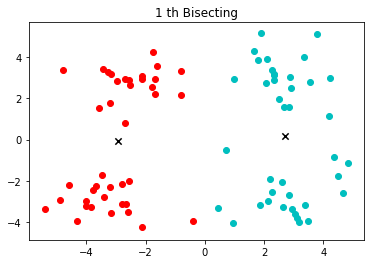

length of len(centList) 2

		 cluster centroid  0  number of cluser 40
		 splitSSE, and notSplitSSE: 87.30471264989171 399.99802121609173 


		 cluster centroid  1  number of cluser 40
		 splitSSE, and notSplitSSE: 62.64959202653465 428.6946327807764 

	 The bestCentroidIndex is : 0
	 the len of bestClustAss is: 40


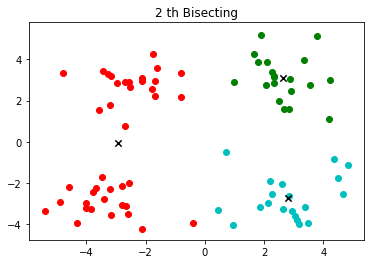

length of len(centList) 3

		 cluster centroid  0  number of cluser 20
		 splitSSE, and notSplitSSE: 28.338601567820938 436.3165071745162 


		 cluster centroid  1  number of cluser 40
		 splitSSE, and notSplitSSE: 62.64959202653465 87.30471264989171 


		 cluster centroid  2  number of cluser 20
		 splitSSE, and notSplitSSE: 20.559350274858417 450.98424790755917 

	 The bestCentroidIndex is : 1
	 the len of bestClustAss is: 40


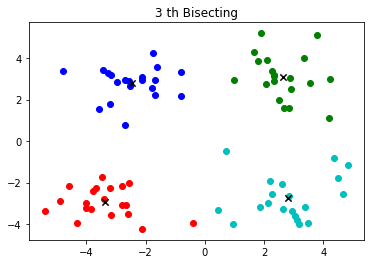

In [29]:
'''
在 dataSet.txt 上运行，可以看出，bisecting k-means 的分类效果确实要优于普通的 k-means。
逐步分解更加宜于收敛到全局最优。
'''
biCents, biAss = biKmeans(dataMat,4)

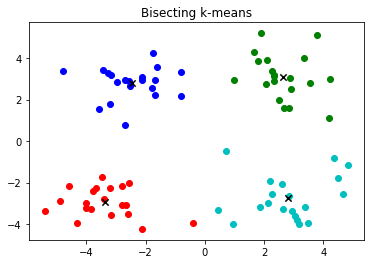

In [30]:
plotKmeans(dataMat,biAss,biCents, 'Bisecting k-means')

length of len(centList) 1

		 cluster centroid  0  number of cluser 60
		 splitSSE, and notSplitSSE: 453.0334895807502 0.0 

	 The bestCentroidIndex is : 0
	 the len of bestClustAss is: 60


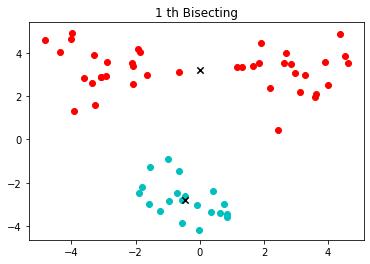

length of len(centList) 2

		 cluster centroid  0  number of cluser 20
		 splitSSE, and notSplitSSE: 12.753263136887313 423.8762401366249 


		 cluster centroid  1  number of cluser 40
		 splitSSE, and notSplitSSE: 77.59224931775066 29.15724944412535 

	 The bestCentroidIndex is : 1
	 the len of bestClustAss is: 40


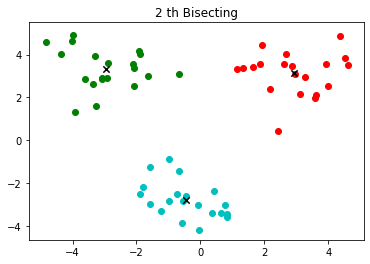

In [31]:
'''
在 testSet2.txt 上运行 bisecting k-means 分类。
'''
dataMat2 = loadDataset('testSet2.txt')
biCents2, biAss2 = biKmeans(dataMat2,3)